# Tehtävä 4: koneoppimisen ja syväoppimisen toteutus 

Tässä dokumentissa sovelletaan koneoppimisen ja syväoppimisen malleja aikaisemmin käsiteltyyn dataan. Tarkoituksena on ennustaa järjestelmien hintaa käyttäen regressiota.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import plotly.express as px
# from pandas_profiling import ProfileReport
# from sklearn.impute import KNNImputer
import seaborn as sns
df = pd.read_csv("./data/base.csv", low_memory=False)


pd.options.display.max_columns = None
#pd.set_option('display.float_format', str)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Muutetaan päivänmäärä pelkästään vuodeksi, koska scalerit eivät toimi datatimen kanssa
df["installation_date"] = pd.to_datetime(df['installation_date']).dt.year

### Luetaan aikaisemmin käsitelty dataframe ja muodostetaan siitä erilaiset versiot

In [3]:
# Otetaan mukaan residential-järjestelmät, missä ei ole akkua
res = df[(df['residential'] == 1) & (df['battery'] == 0)]
# Otetaan mukaan residential-järjestelmät, missä on akku
res_bat = df[(df['residential'] == 1) & (df['battery'] == 1)]

# Otetaan mukaan non_residential-järjestelmät, missä ei ole akkua
non_res = df[(df['residential'] == 0) & (df['battery'] == 0)]
# Otetaan mukaan non_residential-järjestelmät, missä on akku
non_res_bat = df[(df['residential'] == 0) & (df['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

### Tehtävään valitut algoritmit

-Regressiomallit kuvaavat yhteyttä syötemuuttujien ja valitun tarkasteltavan muuttujan välillä. Regressiomenetelmät kuten lineaariregressio  tuottavat vastaukseksi lukuarvon, jonka ei tarvitse olla kokonaisluku. Tästä syystä se sopii hyvin tässä projektissa esimerkiksi hinnan ennustamiseen. Kaikki tarkasteluun otetut algoritmit ovat regressiomalleja. Tavoitteena on ajaa testit valituille malleille ja löytää niistä lähtökohtaisesti 3 parasta mallia, ja tämän jälkeen hienosäätää valitut mallit mahdollisimman tehokkaiksi.

In [4]:
from math import sqrt
from pandas import MultiIndex, Int16Dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [5]:
random_state = 42
models = {"LinearRegression":LinearRegression(),
            "Lasso":linear_model.Lasso(alpha=0.1),
            "Linear Support Vector Regression": LinearSVR(random_state=random_state),
            "Support Vector Regression":svm.SVR(),            
            "Nearest Neighbors Regression":KNeighborsRegressor(),
            "Decision tree regressor":DecisionTreeRegressor(random_state=random_state),
            "RandomForest": RandomForestRegressor(random_state=random_state),
            "Gradient Tree Boosting":GradientBoostingRegressor(random_state=random_state),
            "AdaBoost regressor": AdaBoostRegressor(random_state=random_state),
            "XGBoost Regressor": XGBRegressor(seed = random_state)
            }

## Algoritmien vertailu

Rakennetaan funktio, jolle voi antaa parametrina eri datasettejä ja eri normalisointi funktiota. Funktio palauttaa dataframen missä on jokaiselle algoritmille laskettu arvot eri metriikoita käyttäen ja samalla piirretään kuvaaja, missä näkyy mielestämme mielenkiintoisin sarake eli 
ennustuksen Mean absolute error.

### Algoritmien paremmuuden määrittämiseen käytettiin seuraavia metriikoita: 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 

In [6]:
def evaluate_models(df,scaler,models):    
    random_state = 42

    tulos = pd.DataFrame

    y = df["total_installed_price"]
    X = df.drop(columns="total_installed_price")

    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

    tulos = pd.DataFrame(columns=["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"])
    
    
    if scaler is not None:

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)


    for name, model in models.items():
        

        model.fit(X_train,y_train)

        RMSE_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
        RMSE_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
        r2_test = r2_score(y_test, model.predict(X_test))
        r2_train = r2_score(y_train, model.predict(X_train))
        MAE_test = mean_absolute_error(y_test, model.predict(X_test))
        MAE_train = mean_absolute_error(y_train, model.predict(X_train))

        tulos.loc[len(tulos)] = [name,scaler,RMSE_train,RMSE_test,r2_train,r2_test,MAE_train,MAE_test]

        # if name == "XGBoost Regressor":
        #     print(model.feature_importances_)
        
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Mean absolute error test set")
    sns.barplot(data=tulos,x ="Model", y="MAE test")
    plt.xticks(rotation=45,ha="right")
    plt.subplot(1,2,2)
    plt.title("R2 score testset")
    sns.barplot(data=tulos,x ="Model", y="R2 test")
    plt.xticks(rotation=45,ha="right")

    plt.show()
        
    
    return tulos

In [14]:
res_bat.describe().T

,count,mean,std,min,25%,50%,75%,max
installation_date,6100.0,2018.046721,1.600320,2007.000000,2018.000000,2018.000000,2019.000000,2019.000000
system_size_DC,6100.0,8.279198,10.395724,0.670000,6.120000,7.540000,9.280000,775.200000
total_installed_price,6100.0,37836.217561,21368.700249,1.000000,28000.000000,35000.000000,43789.900000,916861.700000
rebate_or_grant,6100.0,214.263115,1277.841325,0.000000,0.000000,0.000000,0.000000,22614.000000
expansion_system,6100.0,0.020164,0.140572,0.000000,0.000000,0.000000,0.000000,1.000000
multiple_phase_system,6100.0,0.005246,0.072244,0.000000,0.000000,0.000000,0.000000,1.000000
tracking,6100.0,0.002623,0.051152,0.000000,0.000000,0.000000,0.000000,1.000000
ground_mounted,6100.0,0.021148,0.143888,0.000000,0.000000,0.000000,0.000000,1.000000
zip_code,6100.0,93248.615082,1439.984837,90047.000000,92065.000000,92677.000000,94564.000000,96080.000000
third_party_owned,6100.0,0.184098,0.387596,0.000000,0.000000,0.000000,0.000000,1.000000


- Ensimmäisenä käsittelyyn res_bat, joka sisältää akullisia residential tietoja
- Tässä setissä hinnan keskiarvo = 37836.217561

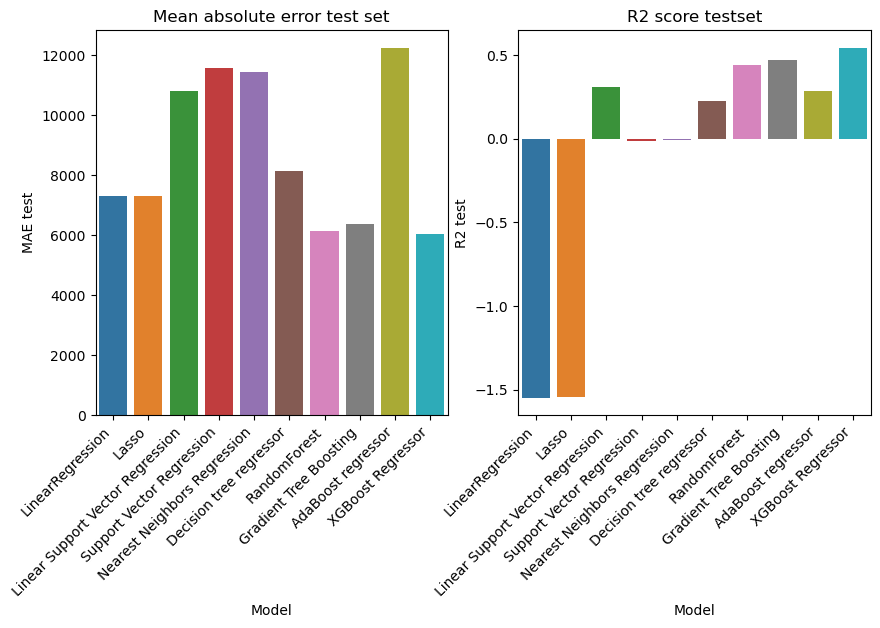

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,None,12664.630903,41260.077543,0.544618,-1.547141,6318.779740,7287.274279
1,Lasso,None,12664.644033,41247.236891,0.544617,-1.545556,6318.376430,7286.120686
2,Linear Support Vector Regression,None,17523.002200,21533.281747,0.128219,0.306234,10565.852330,10804.031657
3,Support Vector Regression,None,18973.589589,26018.103825,-0.022091,-0.012848,11275.442523,11548.810125
4,Nearest Neighbors Regression,None,14969.267098,25953.500362,0.363803,-0.007824,8808.198283,11425.739320
5,Decision tree regressor,None,170.083200,22727.774971,0.999918,0.227130,3.941277,8135.162350
6,RandomForest,None,4983.266001,19402.868889,0.929495,0.436719,2112.188250,6131.352758
7,Gradient Tree Boosting,None,8603.423088,18784.068973,0.789848,0.472075,5103.047354,6364.658720
8,AdaBoost regressor,None,15214.364312,21829.496164,0.342799,0.287015,12007.627786,12211.656194
9,XGBoost Regressor,None,3103.110937,17471.709062,0.972661,0.543266,2006.616193,6028.362856


In [7]:
evaluate_models(res_bat,None,models)

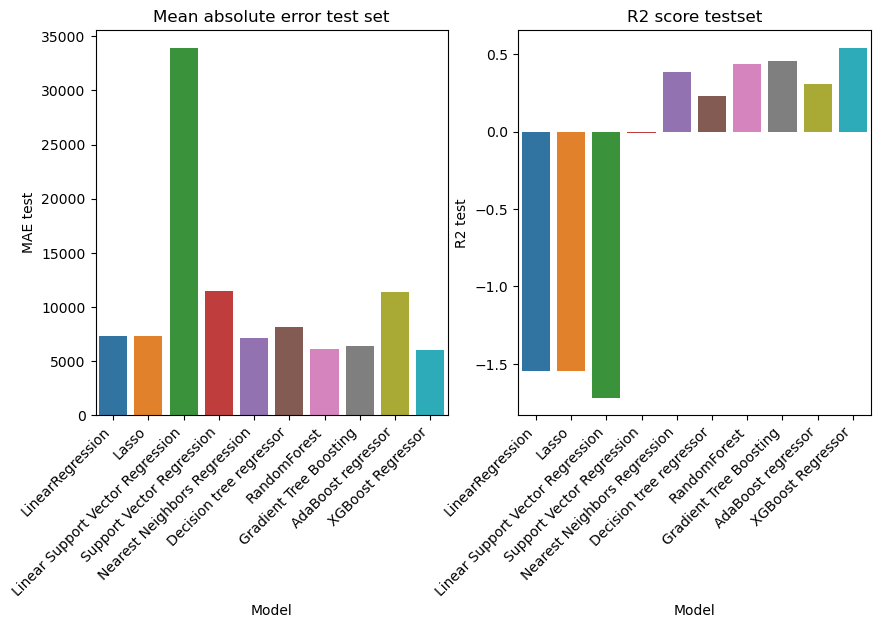

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,StandardScaler(),12664.630903,41260.077543,0.544618,-1.547141,6318.779740,7287.274279
1,Lasso,StandardScaler(),12664.631019,41255.145817,0.544618,-1.546532,6318.660137,7287.014644
2,Linear Support Vector Regression,StandardScaler(),38600.178345,42621.800904,-3.230279,-1.718044,33747.112760,33883.729507
3,Support Vector Regression,StandardScaler(),18933.729173,25990.203239,-0.017801,-0.010677,11228.988367,11503.482105
4,Nearest Neighbors Regression,StandardScaler(),11367.994826,20283.793278,0.633091,0.384410,5436.164517,7152.758594
5,Decision tree regressor,StandardScaler(),170.083200,22709.940312,0.999918,0.228342,3.941277,8121.393785
6,RandomForest,StandardScaler(),4968.135440,19411.889997,0.929923,0.436196,2109.168405,6120.895660
7,Gradient Tree Boosting,StandardScaler(),8603.423088,19015.405117,0.789848,0.458992,5103.047354,6367.849784
8,AdaBoost regressor,StandardScaler(),14472.171752,21505.552438,0.405355,0.308019,11043.656741,11396.233809
9,XGBoost Regressor,StandardScaler(),3103.110937,17468.560783,0.972661,0.543430,2006.616193,6022.937653


In [8]:
evaluate_models(res_bat,StandardScaler(),models)

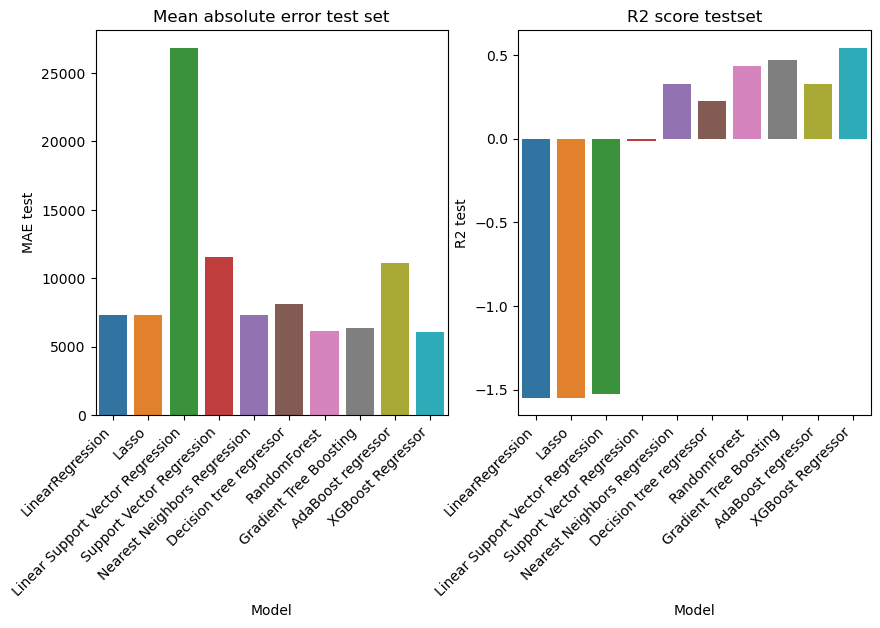

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,RobustScaler(),12664.630903,41260.077543,0.544618,-1.547141,6318.779740,7287.274279
1,Lasso,RobustScaler(),12664.631387,41256.984716,0.544618,-1.546759,6318.671508,7286.914150
2,Linear Support Vector Regression,RobustScaler(),30464.324380,41061.485377,-1.634957,-1.522680,26121.081082,26787.971113
3,Support Vector Regression,RobustScaler(),18972.926938,26017.666392,-0.022019,-0.012814,11274.853826,11548.349552
4,Nearest Neighbors Regression,RobustScaler(),11896.816928,21226.261784,0.598161,0.325876,5573.742353,7317.617393
5,Decision tree regressor,RobustScaler(),170.083200,22722.670499,0.999918,0.227477,3.941277,8129.058023
6,RandomForest,RobustScaler(),4992.745015,19476.026121,0.929227,0.432464,2112.275940,6121.593965
7,Gradient Tree Boosting,RobustScaler(),8603.423088,18782.112969,0.789848,0.472185,5103.047354,6361.209867
8,AdaBoost regressor,RobustScaler(),14202.623324,21235.355541,0.427300,0.325298,10789.878167,11092.341216
9,XGBoost Regressor,RobustScaler(),2905.525676,17470.955593,0.976032,0.543305,1879.366879,6072.930941


In [9]:
evaluate_models(res_bat,RobustScaler(),models)

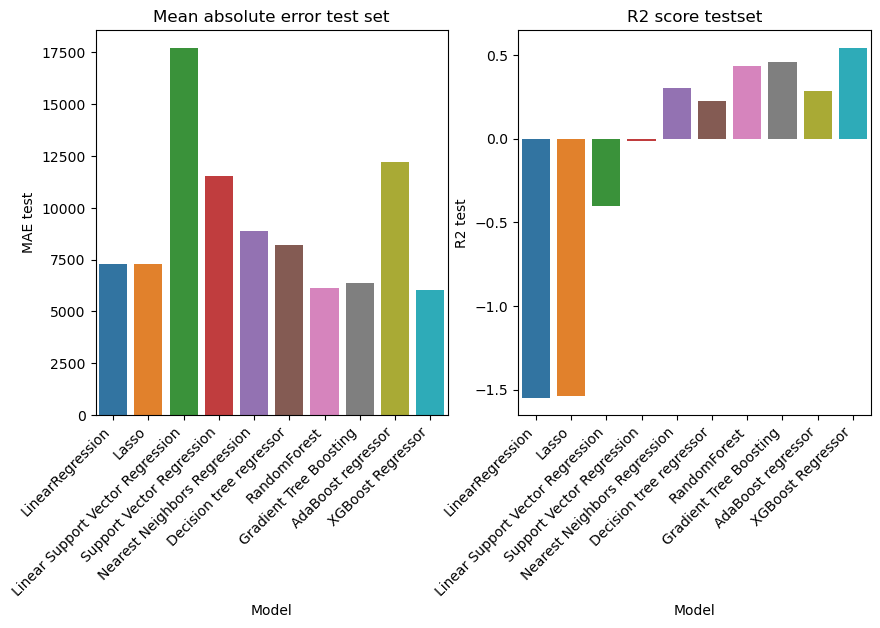

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,MinMaxScaler(),12664.630903,41260.077543,0.544618,-1.547141,6318.779740,7287.274279
1,Lasso,MinMaxScaler(),12664.659711,41173.016021,0.544616,-1.536403,6317.270274,7283.639237
2,Linear Support Vector Regression,MinMaxScaler(),25058.631674,30641.836584,-0.782810,-0.404826,17440.022367,17686.969622
3,Support Vector Regression,MinMaxScaler(),18957.732819,26007.268404,-0.020383,-0.012004,11256.181074,11530.070197
4,Nearest Neighbors Regression,MinMaxScaler(),12864.589374,21615.300163,0.530125,0.300938,6809.437711,8858.191819
5,Decision tree regressor,MinMaxScaler(),170.083200,22787.848960,0.999918,0.223038,3.941277,8187.434078
6,RandomForest,MinMaxScaler(),4976.622144,19418.843740,0.929683,0.435792,2111.382616,6126.592927
7,Gradient Tree Boosting,MinMaxScaler(),8603.423088,19008.266250,0.789848,0.459398,5103.047354,6364.757212
8,AdaBoost regressor,MinMaxScaler(),15214.364312,21829.496164,0.342799,0.287015,12007.627786,12211.656194
9,XGBoost Regressor,MinMaxScaler(),3103.110937,17471.622330,0.972661,0.543270,2006.616193,6025.383609


In [10]:
evaluate_models(res_bat,MinMaxScaler(),models)

## Poikkeamien käsittely

Edelliset tulokset saatiin dataframesta, missä ei oltu poistettu poikkeamia.
Ajetaan samat testit uudestaan dataframella, missä poikkeamat ovat poistettu ja tutkitaan muuttuuko ennusteet.

In [11]:
res_bat_clean = res_bat.copy()

# features = ['system_size_DC', 'total_installed_price',        
#         'inverter_loading_ratio', 'module_quantity','module_efficiency',
#         'inverter_quantity', 'inverter_total_capacity']

features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']


res_bat_clean.head()

for col in features:

        alaraja, ylaraja = np.percentile(a=res_bat_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        res_bat_clean = res_bat_clean[(res_bat_clean[col] > alaraja_iqr) & (res_bat_clean[col] < ylaraja_iqr)]


res_bat_clean.describe().T

system_size_DC Alaraja = 6.12 Yläraja = 9.28 IQR = 3.1599999999999993
total_installed_price Alaraja = 27749.8 Yläraja = 42249.0 IQR = 14499.2
inverter_loading_ratio Alaraja = 0.909926470588235 Yläraja = 1.16279069767442 IQR = 0.25286422708618506
module_quantity Alaraja = 19.0 Yläraja = 28.0 IQR = 9.0
module_efficiency Alaraja = 0.180379746835443 Yläraja = 0.200157214393851 IQR = 0.019777467558408007
inverter_total_capacity Alaraja = 6.239999999999982 Yläraja = 7.616000000000001 IQR = 1.3760000000000199


,count,mean,std,min,25%,50%,75%,max
installation_date,4386.0,2018.234610,1.127007,2007.000000,2018.000000,2018.000000,2019.000000,2019.000000
system_size_DC,4386.0,7.383255,1.484927,3.579400,6.270000,7.250000,8.400000,12.736286
total_installed_price,4386.0,34546.664352,9292.672640,6500.000000,28641.500000,34365.500000,40320.000000,63988.000000
rebate_or_grant,4386.0,80.653443,754.791618,0.000000,0.000000,0.000000,0.000000,14582.000000
expansion_system,4386.0,0.015732,0.124450,0.000000,0.000000,0.000000,0.000000,1.000000
multiple_phase_system,4386.0,0.003876,0.062144,0.000000,0.000000,0.000000,0.000000,1.000000
tracking,4386.0,0.002280,0.047700,0.000000,0.000000,0.000000,0.000000,1.000000
ground_mounted,4386.0,0.015960,0.125334,0.000000,0.000000,0.000000,0.000000,1.000000
zip_code,4386.0,93384.156407,1433.225078,90056.000000,92067.000000,92883.000000,94588.000000,96080.000000
third_party_owned,4386.0,0.186503,0.389556,0.000000,0.000000,0.000000,0.000000,1.000000


- Seuraavana käsittelyyn res_bat_clean, joka myös sisältää akullisia residential tietoja ja setistä on poikkeamat poistettu
- Tässä setissä hinnan keskiarvo = 34546.664352

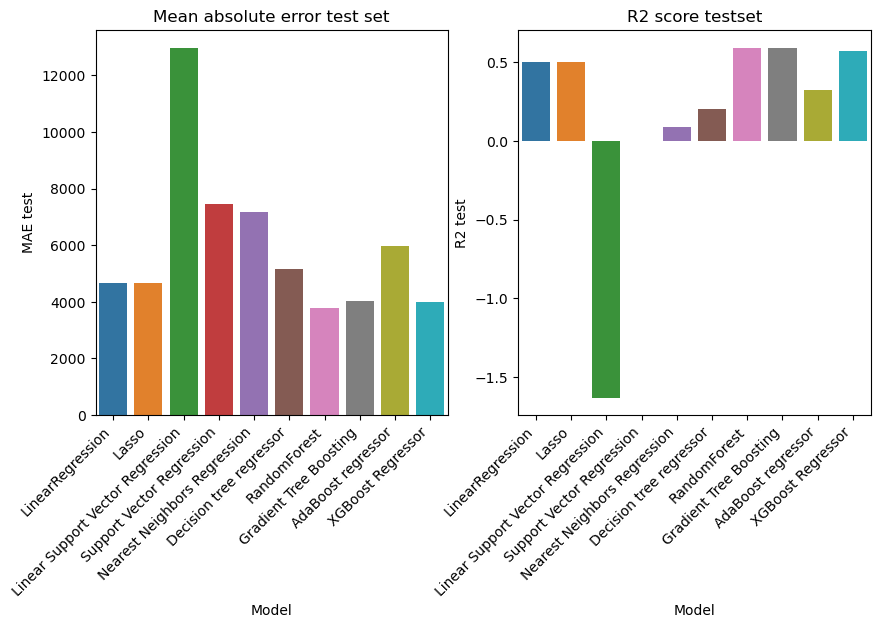

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,None,6653.449981,6612.206162,0.482849,0.501770,4582.014536,4659.552220
1,Lasso,None,6653.485856,6611.295969,0.482843,0.501907,4582.064192,4658.614635
2,Linear Support Vector Regression,None,15326.080008,15190.903641,-1.744011,-1.629688,13317.594606,12949.720865
3,Support Vector Regression,None,9253.977498,9381.624944,-0.000416,-0.002982,7165.870886,7470.319733
4,Nearest Neighbors Regression,None,7056.827825,8951.911196,0.418242,0.086794,5544.449703,7184.617413
5,Decision tree regressor,None,200.365086,8358.662916,0.999531,0.203821,5.227706,5171.325193
6,RandomForest,None,2338.671749,5979.922729,0.936106,0.592499,1455.445068,3800.557429
7,Gradient Tree Boosting,None,5245.579942,6013.517047,0.678552,0.587908,3523.402524,4030.820640
8,AdaBoost regressor,None,7381.897897,7694.550124,0.363410,0.325311,5607.773904,5966.212584
9,XGBoost Regressor,None,1761.183774,6131.611761,0.963765,0.571564,1199.389368,4010.658700


In [12]:
evaluate_models(res_bat_clean,None,models)

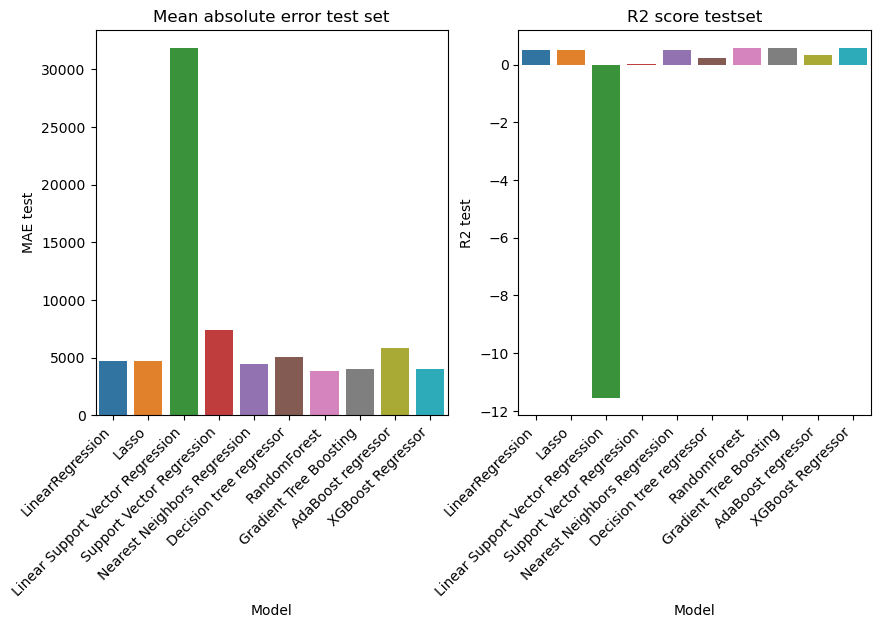

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,StandardScaler(),6653.449981,6612.206162,0.482849,0.501770,4582.014536,4659.552220
1,Lasso,StandardScaler(),6653.450087,6612.146254,0.482849,0.501779,4582.060500,4659.547955
2,Linear Support Vector Regression,StandardScaler(),32833.014165,33174.195255,-11.593463,-11.541164,31502.481025,31824.110912
3,Support Vector Regression,StandardScaler(),9201.301802,9325.198363,0.010941,0.009047,7114.724672,7418.006675
4,Nearest Neighbors Regression,StandardScaler(),5322.772138,6540.651963,0.669022,0.512495,3499.819204,4460.196052
5,Decision tree regressor,StandardScaler(),200.365086,8182.200863,0.999531,0.237083,5.227706,5058.294669
6,RandomForest,StandardScaler(),2337.977648,5980.940480,0.936144,0.592361,1455.880161,3800.051435
7,Gradient Tree Boosting,StandardScaler(),5245.579942,6013.239499,0.678552,0.587946,3523.402524,4029.359204
8,AdaBoost regressor,StandardScaler(),7248.504196,7565.606444,0.386209,0.347734,5434.698169,5801.817991
9,XGBoost Regressor,StandardScaler(),1761.183774,6136.871714,0.963765,0.570828,1199.389368,4014.900848


In [13]:
evaluate_models(res_bat_clean,StandardScaler(),models)

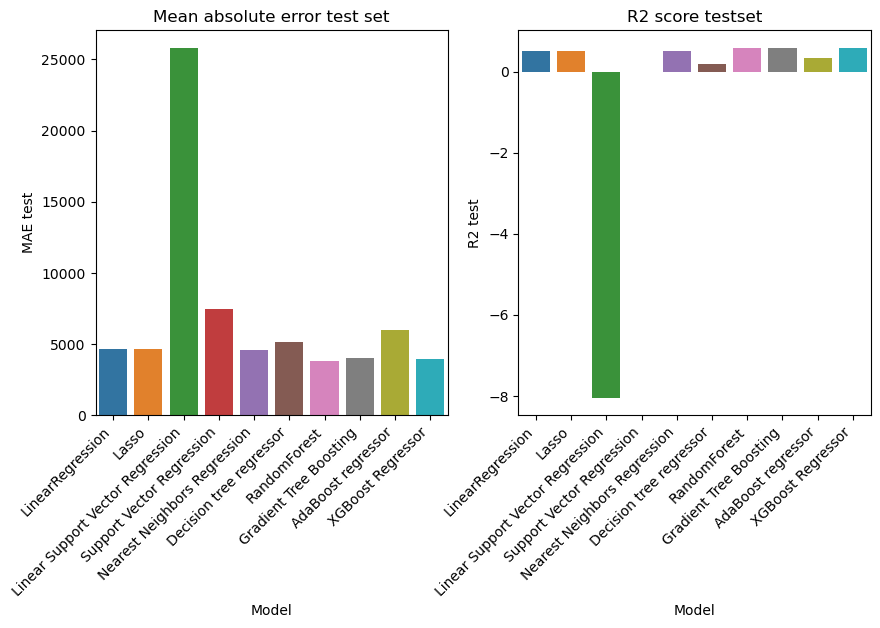

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,RobustScaler(),6653.449981,6612.206162,0.482849,0.501770,4582.014536,4659.552220
1,Lasso,RobustScaler(),6653.451292,6612.151419,0.482849,0.501778,4581.989785,4659.497856
2,Linear Support Vector Regression,RobustScaler(),27860.807747,28171.802708,-8.067991,-8.044120,25618.831632,25766.352764
3,Support Vector Regression,RobustScaler(),9253.721585,9381.355567,-0.000360,-0.002925,7165.674272,7470.108702
4,Nearest Neighbors Regression,RobustScaler(),5618.913069,6648.049578,0.631168,0.496354,3681.898037,4580.235836
5,Decision tree regressor,RobustScaler(),200.365086,8473.313490,0.999531,0.181830,5.227706,5156.713978
6,RandomForest,RobustScaler(),2339.277371,5986.624679,0.936073,0.591586,1456.769930,3810.243327
7,Gradient Tree Boosting,RobustScaler(),5245.579942,6009.229068,0.678552,0.588496,3523.402524,4029.991378
8,AdaBoost regressor,RobustScaler(),7381.897897,7694.550124,0.363410,0.325311,5607.773904,5966.212584
9,XGBoost Regressor,RobustScaler(),1738.262656,6021.875241,0.964702,0.586762,1171.602196,3931.412548


In [14]:
evaluate_models(res_bat_clean,RobustScaler(),models)

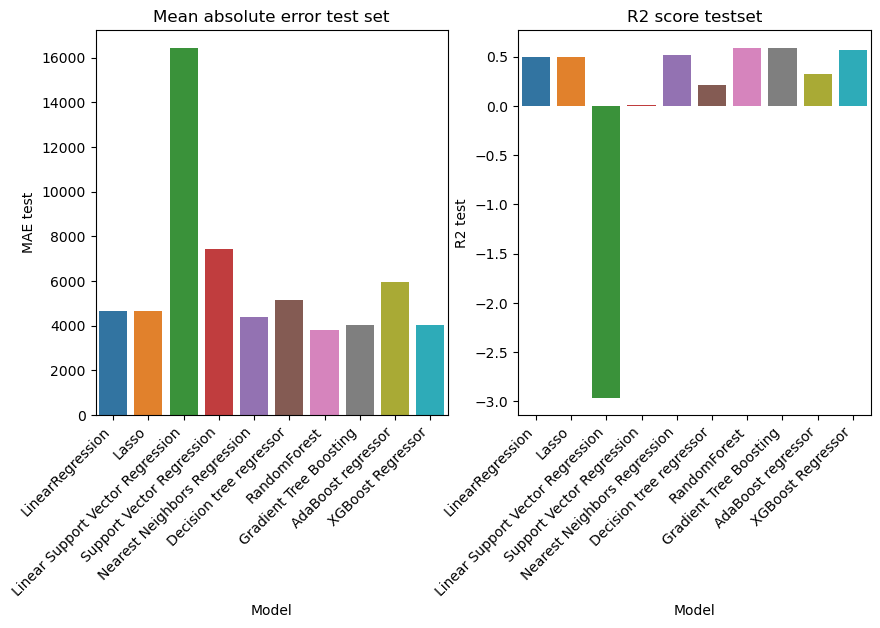

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,LinearRegression,MinMaxScaler(),6653.449981,6612.206162,0.482849,0.501770,4582.014536,4659.552220
1,Lasso,MinMaxScaler(),6653.453600,6611.914485,0.482848,0.501814,4582.321485,4659.594922
2,Linear Support Vector Regression,MinMaxScaler(),18300.395902,18648.494819,-2.912412,-2.963005,16130.195702,16411.048912
3,Support Vector Regression,MinMaxScaler(),9217.336351,9342.483527,0.007491,0.005370,7132.088137,7435.462452
4,Nearest Neighbors Regression,MinMaxScaler(),5503.077790,6479.840328,0.646219,0.521518,3628.199223,4375.392529
5,Decision tree regressor,MinMaxScaler(),200.365086,8336.128493,0.999531,0.208108,5.227706,5154.912065
6,RandomForest,MinMaxScaler(),2339.818130,5979.899519,0.936043,0.592503,1455.217291,3800.468089
7,Gradient Tree Boosting,MinMaxScaler(),5245.579942,6012.557468,0.678552,0.588040,3523.402524,4030.618145
8,AdaBoost regressor,MinMaxScaler(),7381.897897,7694.550124,0.363410,0.325311,5607.773904,5966.212584
9,XGBoost Regressor,MinMaxScaler(),1761.183774,6137.215108,0.963765,0.570780,1199.389368,4014.991260


In [15]:
evaluate_models(res_bat_clean,MinMaxScaler(),models)

### Mietteitä ja huomioita akullisista residential systeemeistä

- Poikkeamien poistaminen laski MAE:n arvoa noin 2000:lla ja R2 scoressa oli myös pieniä parannuksia
- MAE heitti parhaimmillaan 3800 pohjatotuudesta, mikä keskiarvoon nähden ei ole huono, mutta ei myöskään loistava
- Kaikkien algoitmien R2 train oli huomattavasti parempi, mitä vastaava R2 test. Tästä voisi päätellä, että mallit ovat reippaasti ylioppineita

### Käytössä olevien algoritmien määrän vähentäminen

Esikarsinnan tuloksena valikoitui 3 algoritmia: RandomForest, Gradient Tree Boosting, ja XGBoost Regressor. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. 
 
Päätöspuiden avulla pyritään kuvaamaan dataa puurakenteen avulla. Oksat kuvaavat datapisteestä tehtyjä havaintoja ja solmut johtopäätöksiä datapisteen siitä muuttujasta, jota päätöspuun avulla halutaan ennakoida. Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin ,joten ne soveltuvat hyvin tähän projektiin.
 
Oikein säädettynä gradienttitehostetuiden puiden pitäisi suoriutua paremmin kuin satunnaismetsä(random forest tree). Tehostetut puut luovat yhden puun kerrallaan ja jokainen uusi puu yrittää parantaa edellisen puun suoritusta. Satunnaismetsä kouluttaa jokaisen puun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.



### Hyperparametrien optimointi
Tehdään hyperparametrien optimointi käyttäen sklearnin RandomizedSearchCV algortimia. Käytetyllä Skaalajalla/normalisoijalla ei näytä olevan suurta merkitystä ennustusten tarkkuuteen varsinkaan kolmella valitulla algoritmilla. Mutta päädyimme käyttämään standardscaleria, koska se tuntuu hieman nopeuttavan suoritusta


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_state= 42

y = res_bat_clean["total_installed_price"]
X = res_bat_clean.drop(columns="total_installed_price")

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 


#Ensimmäisenä RandomForestRegressor


param_grid = [
                {'n_estimators': [100, 500, 1000], 'max_features': [5, 10, None], 
                'max_depth': [10, 50, None], 'bootstrap': [True, False]}
                ]

model = RandomForestRegressor(random_state=random_state)

grid = RandomizedSearchCV(
        model,
        param_grid,
        n_iter=25, scoring='neg_mean_squared_error', verbose=1)


grid.fit(X_train,y_train)

#grid.best_estimator_

grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'n_estimators': 500, 'max_features': 5, 'max_depth': None, 'bootstrap': True}

In [ ]:
param_grid = [
                {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 
                'max_depth': [1,2,3,4,5,10]}
                ]

model = GradientBoostingRegressor(random_state=random_state)

grid = RandomizedSearchCV(
        model,
        param_grid,
        n_iter=25, scoring='neg_mean_squared_error', verbose=1)


grid.fit(X_train,y_train)

grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01}

In [ ]:
param_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}


model = XGBRegressor(seed=random_state)

grid = RandomizedSearchCV(
        model,
        param_grid,
        n_iter=25, scoring='neg_mean_squared_error', verbose=1)


grid.fit(X_train,y_train)

grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'subsample': 0.8999999999999999,
 'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.4}

Otetaan RandomizedSearchCV algoritmin ehdotukset käyttöön ja koitetaan ajaa vielä yksi testi samalla datasetillä

In [16]:
models = {  "RandomForest": RandomForestRegressor(n_estimators=1000,max_features=5,max_depth=None, random_state=random_state),
            "Gradient Tree Boosting":GradientBoostingRegressor(learning_rate=0.01,max_depth=5,n_estimators=1000, random_state=random_state),
            "XGBoost Regressor": XGBRegressor(subsample=0.8999999999999999,n_estimators=1000, max_depth=6,learning_rate=0.01,colsample_bytree= 0.7,colsample_bylevel=0.4,seed = random_state)
            }

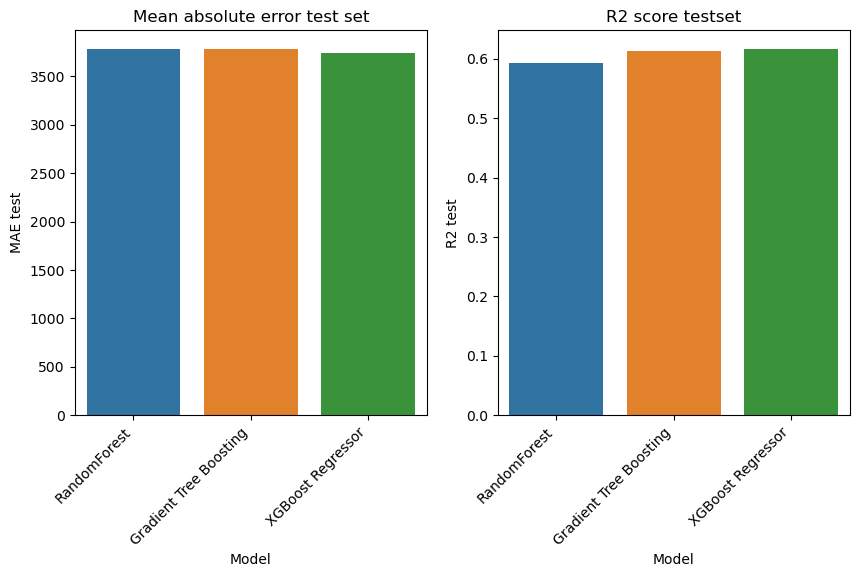

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,StandardScaler(),2311.728402,5976.199006,0.937569,0.593007,1440.033238,3786.902475
1,Gradient Tree Boosting,StandardScaler(),3833.964700,5828.604027,0.828280,0.612862,2615.818284,3785.077880
2,XGBoost Regressor,StandardScaler(),3503.241674,5795.796130,0.856628,0.617208,2355.482337,3745.637937


In [17]:
evaluate_models(res_bat_clean,StandardScaler(),models)

- Käyttämällä RandomizedSearchCV arvoja MAE testin arvot laskivat vielä noin 200-300.
- R2 train arvo tippu XGBoost regressorilla, mutta nousi Gradient Tree:llä. Randomforestilla pysyi melko samana
- R2 test arvot nousivat jokaisella algoritmillä, mikä on hyvä asia. Tosin ne vieläkin ovat 60% kieppeillä

### Seuraava datasetti

-Seuraavaksi käsittelyssä non_res datasetti, mikä pitää sisällään kaikki non_residential kohteet.
- Tässä setissä hinnan keskiarvo = 507551.116563
- Kun poikkeamat on poistettu non_res_clean setistä, keskiarvo = 112427

In [ ]:
non_res.describe().T

,count,mean,std,min,25%,50%,75%,max
installation_date,11243.0,2014.470693,3.301559e+00,1999.000000,2012.000000,2016.000000,2017.00000,2.019000e+03
system_size_DC,11243.0,129.683511,2.488369e+02,0.405000,11.470000,31.680000,128.18400,4.725840e+03
total_installed_price,11243.0,507551.116563,1.084402e+06,0.010000,44398.000000,123456.800000,483708.10000,2.000000e+07
rebate_or_grant,11243.0,12354.157750,1.121663e+05,0.000000,0.000000,0.000000,0.00000,3.500000e+06
expansion_system,11243.0,0.023303,1.508720e-01,0.000000,0.000000,0.000000,0.00000,1.000000e+00
multiple_phase_system,11243.0,0.046874,2.113775e-01,0.000000,0.000000,0.000000,0.00000,1.000000e+00
tracking,11243.0,0.026683,1.611632e-01,0.000000,0.000000,0.000000,0.00000,1.000000e+00
ground_mounted,11243.0,0.156631,3.634685e-01,0.000000,0.000000,0.000000,0.00000,1.000000e+00
zip_code,11243.0,93493.192386,1.576562e+03,90001.000000,92115.000000,93401.000000,94956.00000,9.609600e+04
third_party_owned,11243.0,0.185805,3.889661e-01,0.000000,0.000000,0.000000,0.00000,1.000000e+00


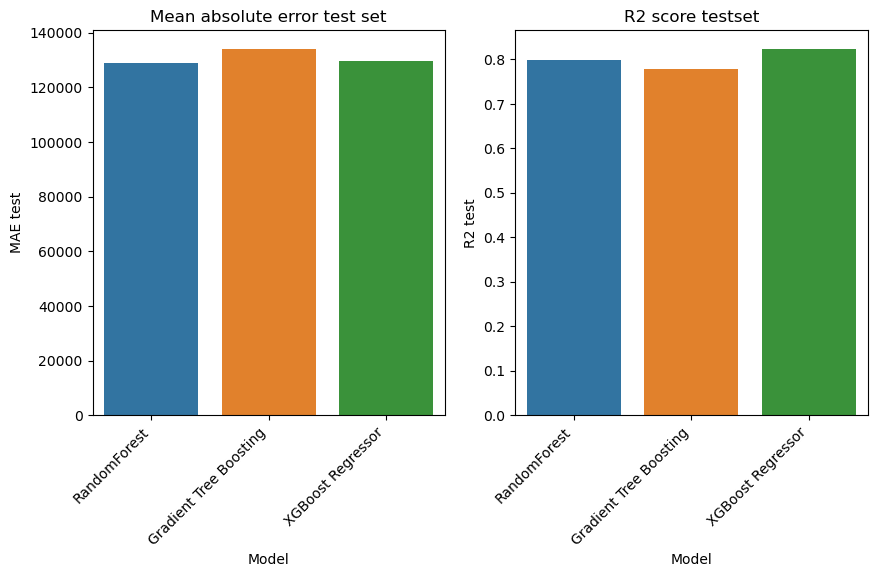

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,StandardScaler(),212361.795188,449996.880390,0.964250,0.797761,51149.987204,129042.985982
1,Gradient Tree Boosting,StandardScaler(),191278.434177,470889.584509,0.970996,0.778546,84269.364387,134156.238824
2,XGBoost Regressor,StandardScaler(),184472.202329,419144.553335,0.973024,0.824542,77699.006096,129607.917275


In [18]:
evaluate_models(non_res,StandardScaler(),models)

In [19]:
non_res_clean = non_res.copy()

features = ['system_size_DC', 'total_installed_price',        
        'inverter_loading_ratio', 'module_quantity','module_efficiency',
        'inverter_quantity', 'inverter_total_capacity']

#features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']


non_res_clean.head()

for col in features:

        alaraja, ylaraja = np.percentile(a=non_res_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        non_res_clean = non_res_clean[(non_res_clean[col] > alaraja_iqr) & (non_res_clean[col] < ylaraja_iqr)]


#non_res_clean.describe().T

system_size_DC Alaraja = 11.47 Yläraja = 128.184 IQR = 116.714
total_installed_price Alaraja = 40000.0 Yläraja = 283392.6575 IQR = 243392.65749999997
inverter_loading_ratio Alaraja = 1.04 Yläraja = 1.206 IQR = 0.16599999999999993
module_quantity Alaraja = 33.0 Yläraja = 187.0 IQR = 154.0
module_efficiency Alaraja = 0.153901899149436 Yläraja = 0.178834420366085 IQR = 0.02493252121664899
inverter_quantity Alaraja = 1.0 Yläraja = 8.0 IQR = 7.0
inverter_total_capacity Alaraja = 7.600000000000031 Yläraja = 39.980000000000146 IQR = 32.380000000000116


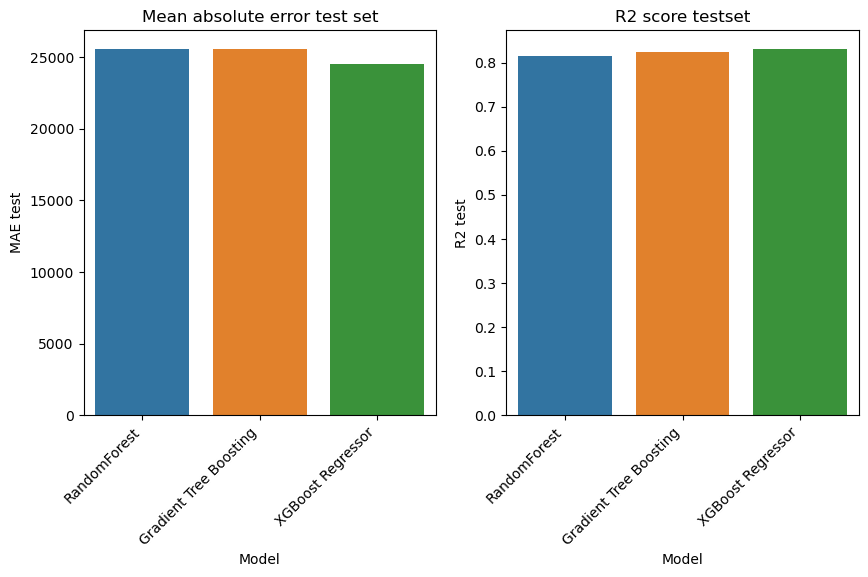

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,StandardScaler(),17889.574639,49817.789104,0.974341,0.815361,9547.972537,25610.013336
1,Gradient Tree Boosting,StandardScaler(),29202.674971,48579.498014,0.931627,0.824426,17635.449334,25609.514410
2,XGBoost Regressor,StandardScaler(),25946.624188,47533.204894,0.946024,0.831907,15311.967530,24529.527346


In [20]:
evaluate_models(non_res_clean,StandardScaler(),models)

### Mietteitä ja huomioita
- Poikkeamien pois ottaminen laski MAE:n arvoa noin 100000 ja samalla r2_test tulos nuosi noin 1 - 5 % algoritmista riippuen.
- Lopullinen MAE arvo oli noin 25000, joka keskiarvoon verrattuna on erittäin iso.
- Tässä setissä R2 train ja R2 test arvot olivat huomattavasti lähempänä toisiaan
- Myös R2 test arvot alkavat olemaan ylu 80%, joka alkaa tuntumaan jo ihan hyvältä arvolta


In [7]:
res_clean = res.copy()

features = ['system_size_DC', 'total_installed_price',        
        'inverter_loading_ratio', 'module_quantity','module_efficiency',
        'inverter_quantity', 'inverter_total_capacity']




for col in features:

        alaraja, ylaraja = np.percentile(a=res_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        res_clean = res_clean[(res_clean[col] > alaraja_iqr) & (res_clean[col] < ylaraja_iqr)]
        
res_clean.describe().T

system_size_DC Alaraja = 4.02 Yläraja = 7.68 IQR = 3.66
total_installed_price Alaraja = 16834.0 Yläraja = 33174.95 IQR = 16340.949999999997
inverter_loading_ratio Alaraja = 1.03991596638655 Yläraja = 1.20833333333333 IQR = 0.1684173669467799
module_quantity Alaraja = 13.0 Yläraja = 25.0 IQR = 12.0
module_efficiency Alaraja = 0.161909184222103 Yläraja = 0.194444444444444 IQR = 0.03253526022234102
inverter_quantity Alaraja = 1.0 Yläraja = 14.0 IQR = 13.0
inverter_total_capacity Alaraja = 3.600000000000003 Yläraja = 6.240000000000019 IQR = 2.6400000000000157


,count,mean,std,min,25%,50%,75%,max
installation_date,524349.0,2015.792838,2.920532,1998.000000,2015.000000,2016.000000,2018.000000,2019.000000
system_size_DC,524349.0,5.577219,2.163785,0.198000,3.924000,5.280000,7.040000,13.149551
total_installed_price,524349.0,24299.369687,11184.520951,0.010000,16400.000000,23470.000000,31434.000000,57686.000000
rebate_or_grant,524349.0,958.878344,2383.929498,0.000000,0.000000,0.000000,772.000000,46459.000000
expansion_system,524349.0,0.008563,0.092140,0.000000,0.000000,0.000000,0.000000,1.000000
multiple_phase_system,524349.0,0.002235,0.047225,0.000000,0.000000,0.000000,0.000000,1.000000
tracking,524349.0,0.005506,0.073997,0.000000,0.000000,0.000000,0.000000,1.000000
ground_mounted,524349.0,0.013642,0.115998,0.000000,0.000000,0.000000,0.000000,1.000000
zip_code,524349.0,93243.728370,1492.737663,0.000000,92114.000000,92880.000000,94544.000000,98654.000000
third_party_owned,524349.0,0.409174,0.491682,0.000000,0.000000,0.000000,1.000000,1.000000


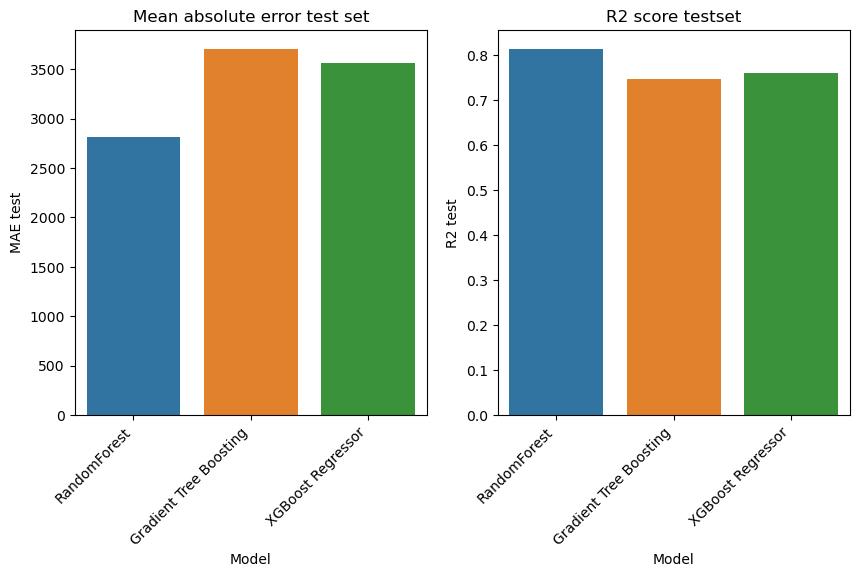

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,StandardScaler(),1776.369446,4801.183398,0.974804,0.815298,1041.237503,2813.896824
1,Gradient Tree Boosting,StandardScaler(),5566.343227,5618.404247,0.752592,0.747070,3678.734880,3708.637262
2,XGBoost Regressor,StandardScaler(),5390.411763,5468.318791,0.767985,0.760403,3512.658284,3558.113768


In [11]:
evaluate_models(res_clean,StandardScaler(),models)

- Viimmeisenä ajettiin res_clean dataset mikä sisälti residential kohteet ilman akkuja. Tämä datasetti oli huomattavasti suurempi mitä kaksi edellistä. Kokoa tällä oli noin 500 000 riviä.
- Tässä datasetissä kirkkaasti parhaiten pärjäsi RandomForest.
- R2 arvot jättivät toivomisen varaa ollen parhaillaan 81% ja muuten 75-76%.
- Setin hinnan keskiarvoon 24299.369687 nähden, randomForestin MAE 2813 tuntuu melko hyvältä, tosin pienempi se voisi olla.


### Neuroverkon testailua



In [8]:
import tensorflow as tf

In [9]:
random_state = 42



y = res_clean["total_installed_price"]
X = res_clean.drop(columns="total_installed_price")

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

scaler_x = StandardScaler()

X_train = pd.DataFrame(scaler_x.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=features)
X_val = pd.DataFrame(scaler_x.transform(X_val), columns=features)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(263484, 26)
(173036, 26)
(87829, 26)


In [10]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64, activation = tf.keras.activations.relu),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128,activation = tf.keras.activations.relu),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64,activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(32,activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1, activation='linear')
])


model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),                
                metrics=['mae'])


In [11]:
hist = model.fit(x=X_train, y=y_train,validation_data=(X_val,y_val), epochs=30 ,batch_size=64 ,verbose=2)

Epoch 1/30
4117/4117 - 12s - loss: 69424544.0000 - mae: 5609.2476 - val_loss: 48803804.0000 - val_mae: 4831.4136 - 12s/epoch - 3ms/step
Epoch 2/30
4117/4117 - 10s - loss: 46039100.0000 - mae: 4683.5776 - val_loss: 44476216.0000 - val_mae: 4571.4399 - 10s/epoch - 2ms/step
Epoch 3/30
4117/4117 - 10s - loss: 42615388.0000 - mae: 4465.5503 - val_loss: 41793188.0000 - val_mae: 4414.8574 - 10s/epoch - 2ms/step
Epoch 4/30
4117/4117 - 10s - loss: 40375780.0000 - mae: 4324.7324 - val_loss: 39506196.0000 - val_mae: 4234.4780 - 10s/epoch - 2ms/step
Epoch 5/30
4117/4117 - 10s - loss: 38914480.0000 - mae: 4228.7090 - val_loss: 38436340.0000 - val_mae: 4164.1841 - 10s/epoch - 2ms/step
Epoch 6/30
4117/4117 - 10s - loss: 38029076.0000 - mae: 4172.3760 - val_loss: 38977824.0000 - val_mae: 4190.4272 - 10s/epoch - 2ms/step
Epoch 7/30
4117/4117 - 10s - loss: 37375460.0000 - mae: 4124.9492 - val_loss: 38228240.0000 - val_mae: 4157.7236 - 10s/epoch - 2ms/step
Epoch 8/30
4117/4117 - 10s - loss: 36794920.0000

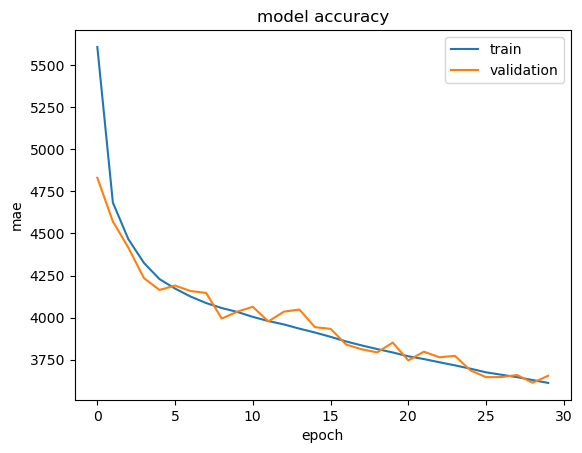

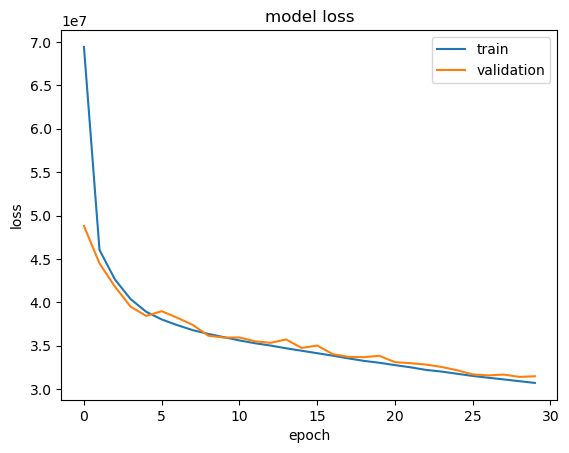

In [12]:
# Piirretään accuracy kuvaaja
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# Piirretään Loss kuvaaja
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
results = model.evaluate(X_test,y_test,batch_size=64)
print(f"Test MeanSquaredError:{results[0]} Test MAE:{results[1]}")

2704/2704 [==============================] - 5s 2ms/step - loss: 31535806.0000 - mae: 3653.5938
Test MeanSquaredError:31535806.0 Test MAE:3653.59375


### Analyysiä syväoppimisesta

- Neuroverkko sai res_clean-datasetin ajettua erittäin nopeasti läpi verrattuna koneoppimisalgoritmeihin.
- Neuroverkossa arvojen skaalaamisella oli erittäin suuri vaikutus lopputulokseen, mikä on luonnollista, koska eri neuronien väliset weight-arvot muuttuvat vähemmän.
- Viimmeisin neuroverkko sai MAE arvon 3653, mikä on samaa tasoa, mitä XGBoost ja Gradient Tree Boostingilla saadut MAE arvot ja huonompi mitä RandomForest
- RMSE = 5615.67503. Tämä on kanssa samaa suuruusluokkaa XGBoost ja Gradient Tree Boostingin kanssa ja huonompi mitä RandomForestilla.
- ROC kuvaajissa voidaan huomata, että Train Loss ja Accuracy pienenee melko jyrkästi, mutta validation loss ja accuracy poukkuoilee oudosti käyrän molemmilla puolilla, mikä ei ole optimaali tilanne. Tosin neuroverkkoa pitää vielä jatkokehittää.

In [ ]:
# Otetaan mallin painoarvot talteen
#model.save("models/model-v1.h5")

#### Jatkokehitysideoita

- Koska mallit tuntuivat olevan ylioppineita, siihen voisi mahdollisesti auttaa käytössä olevien sarakkeiden karsiminen, koska tällä hetkellä mukana on useita sarakkeita, jotka eivät hirveämmin vaikuta lopputulokseen